# Gaussian Process Regression for Time Forecast 

Reference [Docs](https://scikit-learn.org/stable/auto_examples/gaussian_process/plot_gpr_co2.html#sphx-glr-auto-examples-gaussian-process-plot-gpr-co2-py)

## Prepare Notebook
 

In [57]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns
sns.set()

%matplotlib inline

## Generate Data

### 1. Time Variable
 
Let us define a "time" variable $t\in \mathbb{N}$. 

In [58]:
# Number of samples. 
n = 1000
# Generate "time" variable. 
t = np.arange(n)

data_df = pd.DataFrame({'t' : t})

### 2. Seasonal Components

Let us define a function to generate seasonal components (Fourier modes).  

In [59]:
# Generate seasonal variables. 
def seasonal(t, amplitude, period):
    """Generate a sinusoidal curve."""
    y1 = amplitude * np.sin((2*np.pi)*t/period) 
    
    return(y1)

# Add two seasonal components. 
data_df ['s1'] = data_df['t'].apply(lambda t : seasonal(t, amplitude=1, period=30))
data_df ['s2'] = data_df['t'].apply(lambda t : seasonal(t, amplitude=2, period=90))
# Define target variable. 
data_df ['y'] = data_df ['s1'] + data_df ['s2'] 

Let us plot these components:

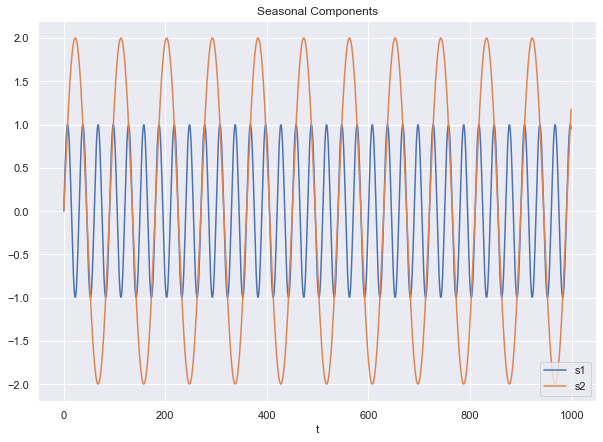

In [60]:
plt.rcParams['figure.figsize'] = [10, 7]

fig, ax = plt.subplots()

data_df .pipe((sns.lineplot, 'data'), x='t', y='s1', label='s1') 
data_df .pipe((sns.lineplot, 'data'), x='t', y='s2', label='s2')

ax.set_title('Seasonal Components');
ax.set_ylabel('t');
ax.set_ylabel('');
ax.legend(loc='lower right');

Now we plot the sum:

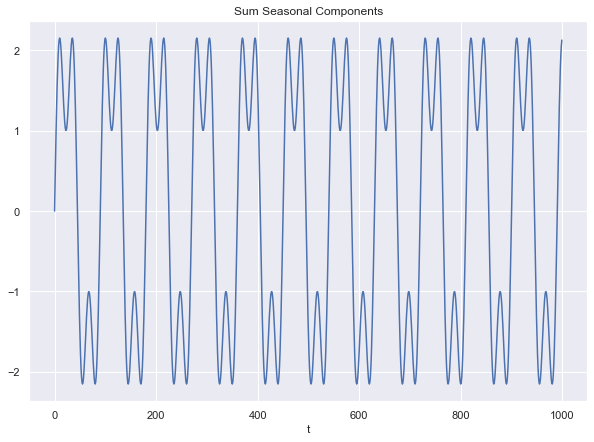

In [61]:
fig, ax = plt.subplots()

data_df .pipe((sns.lineplot, 'data'), x='t', y='y') 

ax.set_title('Sum Seasonal Components');
ax.set_ylabel('t');
ax.set_ylabel('');

### 3. Trend Component

Next we generate a non-linear trend component:

In [62]:
# Generate trend component. 
def trend(t):
    
    trend_comp = 0.5 * np.power(t, 1/2) 
    
    return(trend_comp)

data_df ['y3'] = data_df['t'].apply(trend)

Let us see the trend plot:

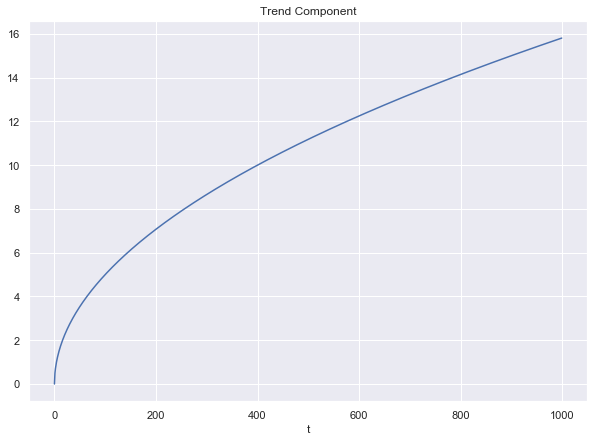

In [63]:
fig, ax = plt.subplots()

data_df.pipe((sns.lineplot, 'data'), x='t', y='y3') 

ax.set_title('Trend Component');
ax.set_ylabel('t');
ax.set_ylabel('');

# Add trend to target variable. 
data_df ['y'] = data_df ['y'] + data_df ['y3']

### 4. Add Gaussian Noise

In [64]:
# Set noise standard deviation. 
sigma_n = 0.3

data_df['epsilon'] = np.random.normal(loc=0, scale=sigma_n, size=n)
# Add noise to target variable. 
data_df ['y'] = data_df ['y'] + data_df ['epsilon']

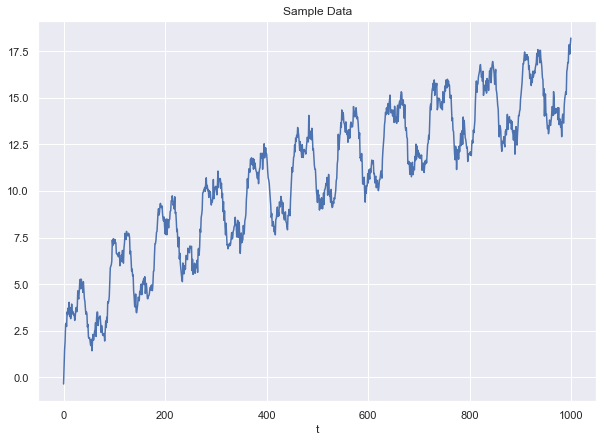

In [65]:
fig, ax = plt.subplots()

data_df .pipe((sns.lineplot, 'data'), x='t', y='y') 

ax.set_title('Sample Data');
ax.set_ylabel('t');
ax.set_ylabel('');

## Define Kernel Structure 

We now construct the predicton kernel:

In [66]:
from sklearn.gaussian_process.kernels \
    import RBF, WhiteKernel, ExpSineSquared, ConstantKernel


k1 = ConstantKernel(constant_value=1.0) * RBF(length_scale_bounds=(1e-5, 1e5)) 

k2 = ConstantKernel(constant_value=1.0) * ExpSineSquared(length_scale=1.0, periodicity_bounds=(10, 50))

k3 = ConstantKernel(constant_value=2.0) * ExpSineSquared(length_scale=1.0, periodicity_bounds=(80, 100))

k4 = RBF(length_scale_bounds=(1e-5, 1)) + WhiteKernel(noise_level=0.1) 

# Add all individual kernel components. 
kernel  = k1 + k2 +k3 #+ k4

In [67]:
from sklearn.gaussian_process import GaussianProcessRegressor
 
# Define GaussianProcessRegressor object. 
gp = GaussianProcessRegressor(kernel=kernel, 
                              alpha=sigma_n, 
                              n_restarts_optimizer=10, 
                              normalize_y=True)

In [68]:
X = data_df['t'].values.reshape(n ,1)
y = data_df['y'].values.reshape(n ,1)

n_train = round(0.8*n)

X_train = X[:n_train]
y_train = y[:n_train]

X_test = X[n_train:]
y_test = y[n_train:]

In [69]:
gp.fit(X_train, y_train)

GaussianProcessRegressor(alpha=0.3, copy_X_train=True,
                         kernel=1**2 * RBF(length_scale=1) + 1**2 * ExpSineSquared(length_scale=1, periodicity=1) + 1.41**2 * ExpSineSquared(length_scale=1, periodicity=1),
                         n_restarts_optimizer=10, normalize_y=True,
                         optimizer='fmin_l_bfgs_b', random_state=None)

In [70]:
y_pred_train = gp.predict(X_train) 
y_pred_test = gp.predict(X_test) 

y_pred, y_std = gp.predict(X, return_std=True)

data_df['y_pred'] = y_pred
data_df['y_std'] = y_std
data_df['y_pred_lwr'] = data_df['y_pred'] - data_df['y_std']
data_df['y_pred_upr'] = data_df['y_pred'] + data_df['y_std']

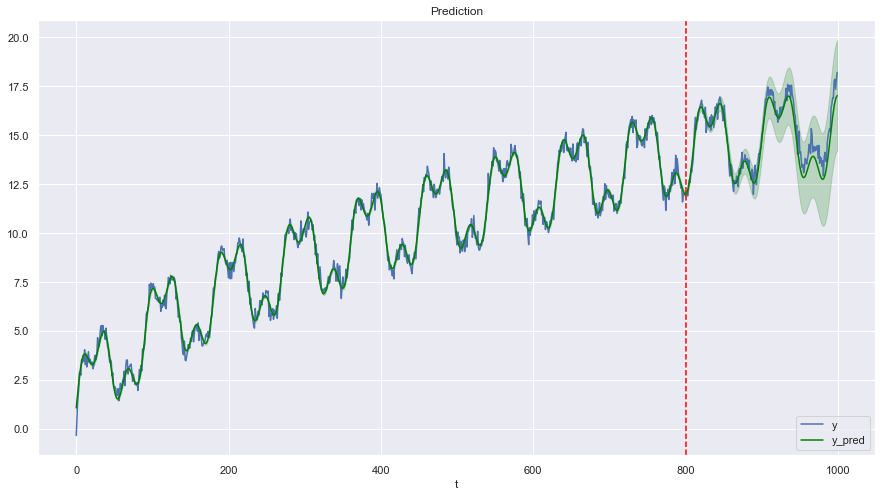

In [72]:
fig, ax = plt.subplots(figsize=(15, 8))

data_df.pipe((sns.lineplot, 'data'), x='t', y='y', label = 'y')
data_df.pipe((sns.lineplot, 'data'), x='t', y='y_pred', label='y_pred',color='green')

ax.fill_between(x=data_df['t'], 
                y1=data_df['y_pred_lwr'], 
                y2=data_df['y_pred_upr'], 
                color='green', 
                alpha=0.2)

ax.axvline(n_train, color='red', linestyle='--')
ax.set_title('Prediction');
ax.set_ylabel('t');
ax.set_ylabel('');
ax.legend(loc='lower right');